In [1]:
import os

import numpy as np
import pandas as pd
import pickle 

from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score

# Plots
import matplotlib.pyplot as plt

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.api.main import Fedot
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

import logging
logging.raiseExceptions = False


In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

## Dataset general preparation

In [3]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df = df.set_index(["case", "t_point"])
df = df.sort_values(["case", "t_point"])
dynamic_idx = list(range(29, 42))
dynamic_columns = list(df.columns[dynamic_idx])
df.loc[:, dynamic_columns]

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                          36.7                   1.93   
        1                          36.3                   2.00   
        2                          36.6                   2.13   
        3                          36.5                   2.12   
GACAAnf 0                           NaN                   1.21   
...                                 ...                    ...   
GACBB;O 0                          36.9                   1.22   
        1                          36.5                   1.65   
GACXAAB 0                          36.5                   1.11   
        1                          36.9                   1.60   
        2                          36.6                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90            74.0            24.0   
        1                 25.70            71.0            19.0   
        2                 32.00             NaN            18.0   
        3                 27.00            71.0            18.0   
GACAAnf 0                 20.70            55.0            22.0   
...                         ...             ...             ...   
GACBB;O 0                 22.34            54.0            18.0   
        1                244.03             NaN            17.0   
GACXAAB 0                 21.80             NaN             NaN   
        1                 60.80            75.0            16.0   
        2                 17.20             NaN            15.0   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                             15.30   
        1                             12.10   
        2                               NaN   
        3                               NaN   
GACAAnf 0                              7.80   
...                                     ...   
GACBB;O 0                              1.43   
        1                              3.78   
GACXAAB 0                              4.50   
        1                              1.10   
        2                              9.30   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

#### Divide it on blocks

We will take from one to four last records and predict next vector

In [4]:
full_df = df.copy()
full_df

омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                        

Exclude columns, which give information about how long and about result

In [5]:
df = df.drop(["end_epizode", "admission_date", "current_process_duration", "process_stages", "outcome_tar", "long_observation_tar"], axis=1)

In [6]:
df.loc[df.index.levels[0][1]]

,омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact,age_stat_fact,трансфузия_dinam_control,оксигенотерапия_dinam_control,НИВЛ_dinam_control,ИВЛ_dinam_control
t_point,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN,1.21,20.7,55.0,22.0,7.8,8.1,0.201,24.1,0,1,189.0,17.7,73,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN,2.09,21.0,72.0,18.0,8.8,7.0,0.204,33.2,0,5,NaN,19.8,73,0,0,0,0


In [7]:
df.loc[df.index.levels[0][10]]

,омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact,age_stat_fact,трансфузия_dinam_control,оксигенотерапия_dinam_control,НИВЛ_dinam_control,ИВЛ_dinam_control
t_point,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0,NaN,1.09,30.3,NaN,18.0,7.5,7.1,0.173,27.3,0,1,180.0,16.1,72,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0,NaN,1.06,31.0,44.0,18.0,NaN,6.5,0.187,16.1,0,5,NaN,21.0,72,0,0,0,0


Разберем одну историю пациента GACAAcY на векторы

In [8]:
t = df.groupby(level=0).nunique().iloc[:, 42:]
pd.DataFrame(t.value_counts())

0
age_stat_fact трансфузия_dinam_control оксигенотерапия_dinam_control НИВЛ_dinam_control ИВЛ_dinam_control      
1             1                        1                             1                  1                  1619
                                       2                             1                  1                   184
                                       1                             1                  2                    61
              2                        1                             1                  2                    34
                                                                                        1                    30
              1                        1                             2                  2                    12
              2                        1                             2                  2                    10
              1                        2                             1                  2                     9
                                       1                             2                  1                     8
              2                        2                             1                  1                     6
                                                                                        2                     6
                                       1                             2                  1                     5
              1                        2                             2                  1                     3
              2                        2                             2                  2                     3
              1                        2                             2                  2                     2

In [9]:
t = df.groupby(level=0).nunique().iloc[:, :29]
pd.DataFrame(t.value_counts())

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0
омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1992


По лекарствам у всех пациентов набор препаратов не менялся, а по процедурам у 380 пациентов изменялся порядок. Из этого сделаем вывод, что можно выделить лекарства и возраст в один вектор, а процедуры не разбираем

Уберем всех пациентов лечившихся меньше 1 недели

In [10]:
s = df.groupby(level=0).size()
df = df.loc[s[s>1].index.values]

Отделим части для обучения и тестирования

In [11]:
test_index = np.random.choice(s.index, 100, replace=False)
train_index = np.array([idx for idx in s.index if idx not in test_index])
df_test = df.loc[test_index, :, :]
df_train = df.loc[train_index, :, :]

C:\Users\sirau\AppData\Local\Temp\ipykernel_12880\2566532452.py:3: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_test = df.loc[test_index, :, :]
C:\Users\sirau\AppData\Local\Temp\ipykernel_12880\2566532452.py:4: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_train = df.loc[train_index, :, :]


### Лимфоциты
Меня интересует зависимость параметров Лимфоциты# и Лимфоциты%

Text(0.5, 1.0, 'Зависимость распределения \n Лимфоциты% от Лимфоциты#')

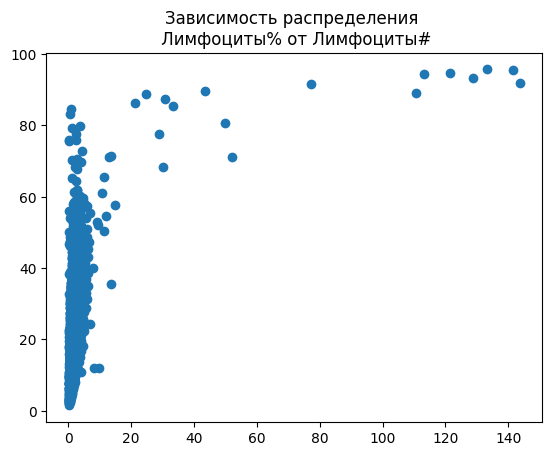

In [12]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
plt.scatter(data[:,0], data[:, 1])
plt.title("Зависимость распределения \n Лимфоциты% от Лимфоциты#")

Text(0.5, 1.0, 'Распределение величины Лимфоциты#_dinam_fact')

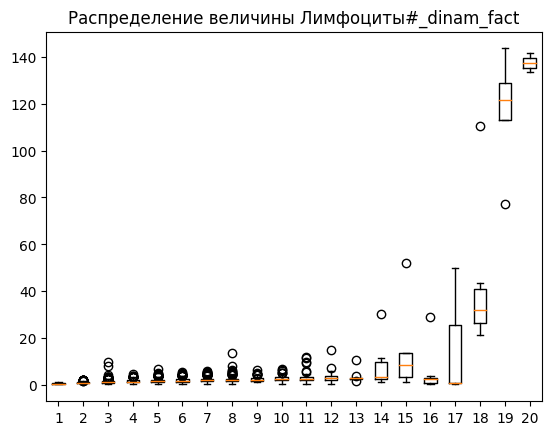

In [13]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = [df[(df["Лимфоциты%_dinam_fact"]>i) & (df["Лимфоциты%_dinam_fact"]<i+5)]["Лимфоциты#_dinam_fact"] for i in range(0, 100, 5)]
plt.boxplot(data)
plt.title("Распределение величины Лимфоциты#_dinam_fact")

Text(0.5, 1.0, 'Распределение величины Лимфоциты%_dinam_fact')

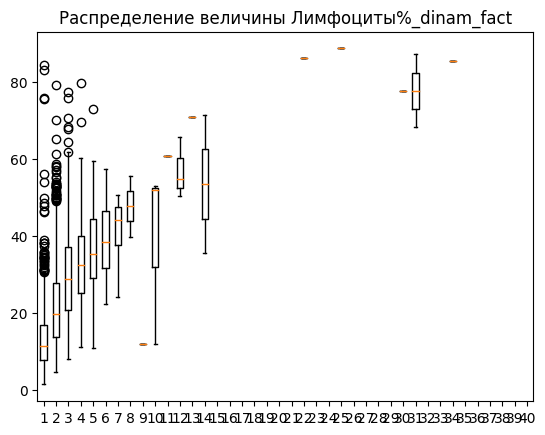

In [14]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = [df[(df["Лимфоциты#_dinam_fact"]>i) & (df["Лимфоциты#_dinam_fact"]<i+1)]["Лимфоциты%_dinam_fact"] for i in range(0, 40, 1)]
plt.boxplot(data)
plt.title("Распределение величины Лимфоциты%_dinam_fact")

Получается, что чистой корреляции у них нет. Однако чем выше количество лимфоцитов, тем больше их часть среди других лейкоцитов. Корреляцию Пирсона получаем 0.35 (P < 1e-159)

In [15]:
from scipy.stats import pearsonr
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = data[~np.isnan(data[:, 0]) & ~np.isnan(data[:, 1]) , :]
pearsonr(data[:, 0], data[:, 1])

PearsonRResult(statistic=0.35366027434981473, pvalue=5.609278436072053e-159)

## Обучение

Теперь разделим датасет на окна - одна запись как фича, другая как таргет. И среди всех записей пациента проведем такую операцию

In [16]:
X , y = [], []
for i in df_train.index.levels[0]:
    try:
        for j in range(df_train.loc[i].index.size - 1):
            try:
                X.append(df_train.loc[(i, j)])
                y.append(df_train.loc[(i, j+1)].iloc[29:42])
            except:
                pass
    except:
        pass
X, y = np.array(X), np.array(y)

Уберем nan значения таргета, и каждому из 13-ти параметров соотнесем пары - вектор параметров X и вектор значений Y. Получим для каждого параметра датафрейм векторов состояния и следующие значения парамтера

In [17]:
data = {param: [] for param in dynamic_columns}
for i in range(len(data)):
    X_temp, y_temp = [], []
    for j in range(y.shape[0]):
        if not np.isnan(y[j][i]):
            X_temp.append(X[j])
            y_temp.append(y[j][i])
    data[dynamic_columns[i]] = {"X": np.array(X_temp), "y": np.array(y_temp)}

Теперь посмотрим, сколько пар для обучения у нас присутствует

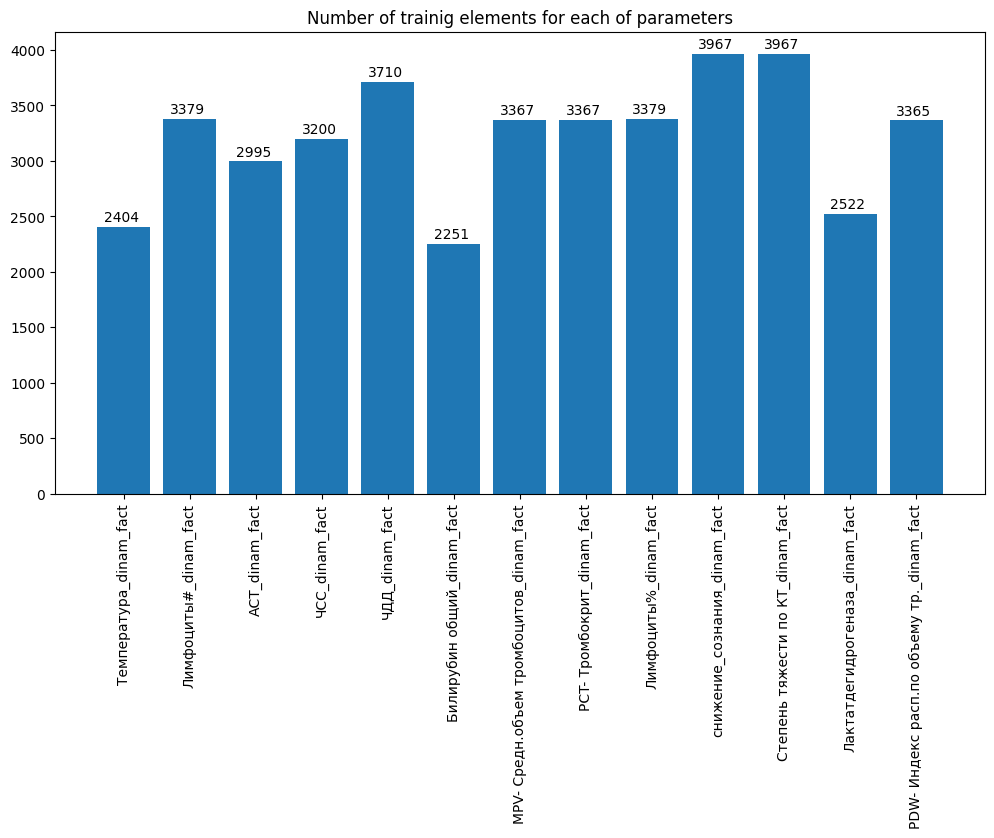

In [18]:
stat_nan = {k:len(data[k]["X"]) for k in data}
l = stat_nan.keys()
h = stat_nan.values()
plt.figure(figsize=(12, 6))
plt.bar(x=l, height=h)
plt.xticks(rotation=90)
plt.title("Number of trainig elements for each of parameters")
for key_idx, key in enumerate(stat_nan):
  plt.text(key_idx-0.3,stat_nan[key]+50,stat_nan[key])

Нам важно измерить качество регрессии. Будем вычислять R2, MSE, mAPE и 95% интервалы этих метрик. Для доверительных интервалов будем использовать значения метрик модели на 5 фолдах (иными словами кросс валидацию)

In [19]:
import scipy.stats as st
def get_scores(y_real, y_pred):
    scores = {}
    scores["r2"] = r2_score(y_real, y_pred, multioutput="raw_values")
    scores["mse"] = mean_squared_error(y_real, y_pred, multioutput="raw_values")
    scores["mape"] = mean_absolute_percentage_error(y_real, y_pred, multioutput="raw_values")
    return scores

def evaluate_with_intervals(clf, X=None, y=None, folds=5, fedot=False):
    scoring_results = {"r2":[], "mape":[], "mse":[]}
    kf = KFold(folds)
    k = 0
    if (fedot):
        for train, test in kf.split(X, y):
            indata_train = InputData(idx=np.arange(0, X[train].shape[0]), 
                  features=X[train],
                  target=y[train],
                  data_type=DataTypesEnum.table,
                  task=Task(TaskTypesEnum.regression))
            clf.fit(indata_train)
            # indata_test = InputData(idx=np.arange(0, X[test].shape[0]), 
            #           features=X[test],
            #           data_type=DataTypesEnum.table,
            #           task=Task(TaskTypesEnum.regression))
            # y_pred = pipeline.predict(indata_test).predict
            # print(f"Model fitted on fold {k} / {folds}")
            # validation_data = get_scores(y[test], y_pred)
            # for sc in scoring_results:
            #     scoring_results[sc].append(validation_data[sc])
            # k+=1
    else:
        for train, test in kf.split(X, y):
            clf.fit(X[train], y[train])
            print(f"Model fitted on fold {k} / {folds}")
            y_pred = clf.predict(X[test])
            validation_data = get_scores( y[test], y_pred)
            for sc in scoring_results:
                scoring_results[sc].append(validation_data[sc])
            k+=1
    # data_df = {}
    # for metric in scoring_results:
    #     dataz = scoring_results[metric]
    #     interval  = st.t.interval(confidence=0.95 , df=len(dataz), loc=np.mean(dataz), scale=st.sem(dataz))
    #     data_df["max_"+metric] = interval[1]
    #     data_df["min_"+metric] = interval[0]
    #     data_df["avg_"+metric] = (interval[1]+interval[0])/2
    # df_metrics = pd.DataFrame(data_df, index=[0])
    # return df_metrics



Чтобы обьективно понимать, что будущие модели будут улавливать закономерности а не рандомно делать свои ответы, попробуем возвращать только среднее значение параметра по всем возможным наблюдениям и после сравним эффективность такого подхода с моделью машинного обучения

### HistGradientBoostingRegressor

Сделаем модели на каждый параметр с простенькой моделью HistGradientBoostingRegressor (она единственная из sklearn ргегрессоров поддерживает NaN)

### LinearRegression

### Fedot

Я распаралеливал эту ячейку, запускал 13 jupyter серверов, можно и последовательно все запустить

In [30]:
for col in list(data.keys()):
    print(f"Start composing {col}")
    model = Fedot(problem="regression", timeout=10, cache_folder="D:\\Cache", use_pipelines_cache=False, use_preprocessing_cache=False)
    pipeline = model.fit(data[col]["X"], data[col]["y"])
    pipeline.save(f"fedot_pipelines_april\\{col}", create_subdir=False, is_datetime_in_path=False)
    print(f"Successfully composed {col} \n")

Start composing Температура_dinam_fact
2023-04-01 13:49:26,804 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 4.8 MiB, max: 10.7 MiB
2023-04-01 13:49:26,812 - ApiComposer - Initial pipeline was fitted in 12.2 sec.
2023-04-01 13:49:26,821 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-04-01 13:49:26,854 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 10 min. Set of candidate models: ['lasso', 'lgbmreg', 'dtreg', 'isolation_forest_reg', 'knnreg', 'adareg', 'ransac_lin_reg', 'gbr', 'rfr', 'normalization', 'ridge', 'poly_features', 'linear', 'ransac_non_lin_reg', 'svr', 'treg', 'scaling', 'fast_ica', 'sgdr', 'pca', 'lasso', 'lgbmreg', 'dtreg', 'isolation_forest_reg', 'knnreg', 'adareg', 'ransac_lin_reg', 'gbr', 'rfr', 'normalization', 'ridge', 'poly_features', 'linear', 'ransac_non_lin_reg', 'svr', 'treg', 'scaling', 'fast_ica', 'sgdr', 'pca'].
2023-

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-01 13:49:46,628 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-01 13:54:51,802 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-01 13:54:51,820 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [05:24<?, ?gen/s]

2023-04-01 13:54:51,871 - ApiComposer - Hyperparameters tuning started with 4 min. timeout


2023-04-01 13:55:24,925 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1, 'max_features': 0.5270786981893213, 'min_samples_split': 6, 'min_samples_leaf': 17, 'bootstrap': True}
scaling - {} 
Initial metric: 0.259
  0%|                                       | 6/100000 [03:07<1043:22:47, 37.56s/trial, best loss: 0.25829976084709727]
2023-04-01 13:59:34,455 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1, 'max_features': 0.20746500144879904, 'min_samples_split': 10, 'min_samples_leaf': 14, 'bootstrap': False}
scaling - {}
2023-04-01 13:59:34,461 - SimultaneousTuner - Final metric: 0.258
2023-04-01 13:59:34,476 - ApiComposer - Hyperparameters tuning finished
2023-04-01 13:59:35,919 - ApiComposer - Model generation finished
2023-04-01 13:59:41,728 - FEDOT logger - Final pipeline was fitted
2023-04-01 13:59:41,732 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-01 14:00:24,060 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-01 14:05:17,580 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-01 14:05:17,591 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [05:14<?, ?gen/s]

2023-04-01 14:05:17,624 - ApiComposer - Hyperparameters tuning started with 5 min. timeout


2023-04-01 14:06:36,535 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1}
scaling - {} 
Initial metric: 1.340
  0%|                                        | 2/100000 [01:52<1564:05:24, 56.31s/trial, best loss: 1.6476942444715217]
2023-04-01 14:09:28,204 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1}
scaling - {}
2023-04-01 14:09:28,210 - SimultaneousTuner - Final metric: 1.340
2023-04-01 14:09:28,225 - ApiComposer - Hyperparameters tuning finished
2023-04-01 14:09:28,547 - ApiComposer - Model generation finished
2023-04-01 14:09:47,115 - FEDOT logger - Final pipeline was fitted
2023-04-01 14:09:47,123 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': -1}
scaling - {}
Memory consumption for finish in main session: current 8.1 MiB, max: 17.4 MiB
Successfully composed Лимфоциты#_dinam_fact 

Start composing АСТ_dinam_fact
2

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-01 14:10:19,339 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-01 14:14:31,587 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-01 14:18:05,718 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-04-01 14:18:05,748 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [07:59<?, ?gen/s]

2023-04-01 14:18:05,791 - ApiComposer - Hyperparameters tuning started with 2 min. timeout


2023-04-01 14:19:27,687 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 5, 'nodes': [rfr, scaling, ransac_lin_reg, normalization, pca]}
rfr - {'n_jobs': 1}
scaling - {}
ransac_lin_reg - {'min_samples': 0.4, 'residual_threshold': 10, 'max_trials': 100, 'max_skips': 1000}
normalization - {}
pca - {'svd_solver': 'full', 'n_components': 0.7} 
Initial metric: 58.599
 10%|█████                                             | 1/10 [01:00<09:04, 60.54s/trial, best loss: 59.84219091669037]
2023-04-01 14:20:28,312 - SimultaneousTuner - Tunner stopped after initial search due to the lack of time
2023-04-01 14:20:28,337 - ApiComposer - Hyperparameters tuning finished
2023-04-01 14:20:28,704 - ApiComposer - Model generation finished
2023-04-01 14:20:41,416 - FEDOT logger - Final pipeline was fitted
2023-04-01 14:20:41,424 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 5, 'nodes': [rfr, scaling, ransac_lin_reg, normalization, pca]}
rfr - {'n_jobs': -1, 'bootstrap': False, 'max_fea

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-01 14:21:17,390 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-01 14:26:41,100 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-01 14:26:41,112 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [05:37<?, ?gen/s]

2023-04-01 14:26:41,150 - ApiComposer - Hyperparameters tuning started with 4 min. timeout


2023-04-01 14:29:33,037 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 4, 'nodes': [rfr, scaling, fast_ica, ransac_lin_reg]}
rfr - {'n_jobs': 1}
scaling - {}
fast_ica - {'whiten': 'unit-variance'}
ransac_lin_reg - {'min_samples': 0.4, 'residual_threshold': 10, 'max_trials': 100, 'max_skips': 1000} 
Initial metric: 15.910
 10%|████▉                                            | 1/10 [01:15<11:23, 75.95s/trial, best loss: 15.878866036044787]
2023-04-01 14:30:49,079 - SimultaneousTuner - Tunner stopped after initial search due to the lack of time
2023-04-01 14:30:49,098 - ApiComposer - Hyperparameters tuning finished
2023-04-01 14:30:49,461 - ApiComposer - Model generation finished
2023-04-01 14:31:06,824 - FEDOT logger - Final pipeline was fitted
2023-04-01 14:31:06,828 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [rfr, scaling, fast_ica, ransac_lin_reg]}
rfr - {'n_jobs': -1, 'bootstrap': False, 'max_features': 0.5912353535135199, 'min_samples_leaf': 15

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-01 14:31:41,921 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-01 14:37:15,795 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-01 14:37:15,811 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [05:47<?, ?gen/s]

2023-04-01 14:37:15,843 - ApiComposer - Hyperparameters tuning started with 4 min. timeout


2023-04-01 14:37:52,467 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1, 'max_features': 0.15764920580027225, 'min_samples_split': 14, 'min_samples_leaf': 12, 'bootstrap': False}
scaling - {} 
Initial metric: 2.200
  0%|                                        | 3/100000 [02:22<1985:40:27, 71.49s/trial, best loss: 2.1986189582262474]
2023-04-01 14:41:39,680 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1, 'max_features': 0.21963381777511432, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': True}
scaling - {}
2023-04-01 14:41:39,684 - SimultaneousTuner - Final metric: 2.199
2023-04-01 14:41:39,699 - ApiComposer - Hyperparameters tuning finished
2023-04-01 14:41:40,076 - ApiComposer - Model generation finished
2023-04-01 14:41:49,503 - FEDOT logger - Final pipeline was fitted
2023-04-01 14:41:49,509 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-01 14:42:15,344 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-01 14:45:11,422 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-01 14:47:44,961 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-04-01 14:47:44,990 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [05:39<?, ?gen/s]

2023-04-01 14:47:45,020 - ApiComposer - Hyperparameters tuning started with 4 min. timeout


2023-04-01 14:48:22,235 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 3, 'nodes': [ridge, ransac_non_lin_reg, scaling]}
ridge - {}
ransac_non_lin_reg - {'min_samples': 0.4, 'residual_threshold': 10, 'max_trials': 100, 'max_skips': 1000}
scaling - {} 
Initial metric: 5.400
 60%|██████████████████████████████                    | 6/10 [03:51<02:34, 38.62s/trial, best loss: 5.392611254485303]
2023-04-01 14:52:13,990 - SimultaneousTuner - Tunner stopped after initial search due to the lack of time
2023-04-01 14:52:14,008 - ApiComposer - Hyperparameters tuning finished
2023-04-01 14:52:14,413 - ApiComposer - Model generation finished
2023-04-01 14:54:42,593 - FEDOT logger - Final pipeline was fitted
2023-04-01 14:54:42,604 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [ridge, ransac_non_lin_reg, scaling]}
ridge - {'alpha': 4.248165982601363}
ransac_non_lin_reg - {'min_samples': 0.4, 'residual_threshold': 10240, 'max_trials': 100, 'max_skips': 1000}
scalin

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-01 14:55:33,103 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-01 14:59:29,973 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-01 15:04:29,681 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-04-01 15:04:29,708 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [09:24<?, ?gen/s]

2023-04-01 15:04:29,737 - ApiComposer - Hyperparameters tuning started with 0 min. timeout


2023-04-01 15:05:08,266 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1, 'max_features': 0.3030319098130757, 'min_samples_split': 11, 'min_samples_leaf': 5, 'bootstrap': False}
scaling - {} 
Initial metric: 0.896
2023-04-01 15:05:08,274 - SimultaneousTuner - Tunner stopped after initial assumption due to the lack of time
2023-04-01 15:05:08,287 - ApiComposer - Hyperparameters tuning finished
2023-04-01 15:05:08,625 - ApiComposer - Model generation finished
2023-04-01 15:05:16,982 - FEDOT logger - Final pipeline was fitted
2023-04-01 15:05:16,991 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': -1, 'max_features': 0.3030319098130757, 'min_samples_split': 11, 'min_samples_leaf': 5, 'bootstrap': False}
scaling - {}
Memory consumption for finish in main session: current 8.1 MiB, max: 17.4 MiB
Successfully composed MPV- Средн.объем тромбоцитов_dinam_fact 

Start composing PCT- Тром

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-01 15:05:49,960 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-01 15:10:47,039 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-01 15:10:47,051 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [05:10<?, ?gen/s]

2023-04-01 15:10:47,081 - ApiComposer - Hyperparameters tuning started with 5 min. timeout


2023-04-01 15:12:03,255 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 3, 'nodes': [rfr, poly_features, scaling]}
rfr - {'n_jobs': 1}
poly_features - {}
scaling - {} 
Initial metric: 0.087
  0%|                                       | 4/100000 [02:41<1118:23:23, 40.26s/trial, best loss: 0.08618772765459977]
2023-04-01 15:15:30,752 - SimultaneousTuner - Final graph: {'depth': 3, 'length': 3, 'nodes': [rfr, poly_features, scaling]}
rfr - {'n_jobs': 1, 'bootstrap': True, 'max_features': 0.7882899435041948, 'min_samples_leaf': 12, 'min_samples_split': 20}
poly_features - {'degree': 4, 'interaction_only': True}
scaling - {}
2023-04-01 15:15:30,760 - SimultaneousTuner - Final metric: 0.086
2023-04-01 15:15:30,772 - ApiComposer - Hyperparameters tuning finished
2023-04-01 15:15:31,137 - ApiComposer - Model generation finished
2023-04-01 15:15:41,718 - FEDOT logger - Final pipeline was fitted
2023-04-01 15:15:41,726 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-01 15:16:23,592 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-01 15:19:59,141 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-01 15:23:26,454 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-04-01 15:23:26,482 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [07:24<?, ?gen/s]

2023-04-01 15:23:26,517 - ApiComposer - Hyperparameters tuning started with 2 min. timeout


2023-04-01 15:23:55,752 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [gbr, scaling]}
gbr - {}
scaling - {} 
Initial metric: 9.437
  0%|                                                                       | 0/100000 [00:00<?, ?trial/s, best loss=?]

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be remo

  0%|                                         | 1/100000 [00:41<1150:20:13, 41.41s/trial, best loss: 9.697743990330265]

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in ve

  0%|                                          | 2/100000 [01:10<949:57:34, 34.20s/trial, best loss: 9.624162184368737]

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be remo

  0%|                                         | 3/100000 [02:10<1206:12:30, 43.42s/trial, best loss: 9.624162184368737]


D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
D:\covid\covid\venv\lib\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in versio

2023-04-01 15:26:33,463 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [gbr, scaling]}
gbr - {}
scaling - {}
2023-04-01 15:26:33,466 - SimultaneousTuner - Final metric: 9.437
2023-04-01 15:26:33,482 - ApiComposer - Hyperparameters tuning finished
2023-04-01 15:26:33,841 - ApiComposer - Model generation finished
2023-04-01 15:26:41,071 - FEDOT logger - Final pipeline was fitted
2023-04-01 15:26:41,078 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [gbr, scaling]}
gbr - {}
scaling - {}
Memory consumption for finish in main session: current 8.3 MiB, max: 17.6 MiB
Successfully composed Лимфоциты%_dinam_fact 

Start composing снижение_сознания_dinam_fact
2023-04-01 15:26:57,366 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 7.9 MiB, max: 17.7 MiB
2023-04-01 15:26:57,374 - ApiComposer - Initial pipeline was fitted in 9.1 sec.
2023-04-01 15:26:57,385 - AssumptionsHandler - Preset was changed to

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-01 15:27:06,708 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-01 15:30:42,456 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-01 23:22:29,100 - MultiprocessingDispatcher - 18 individuals out of 20 in previous population were evaluated successfully.
2023-04-01 23:22:29,131 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                        | 1/10000 [7:55:31<?, ?gen/s]

2023-04-01 23:22:29,160 - ApiComposer - Time for pipeline composing was 7:55:31.628208.
The remaining 465.7 seconds are not enough to tune the hyperparameters.
2023-04-01 23:22:29,167 - ApiComposer - Composed pipeline returned without tuning.


2023-04-01 23:22:29,529 - ApiComposer - Model generation finished
2023-04-01 23:22:36,859 - FEDOT logger - Final pipeline was fitted
2023-04-01 23:22:36,867 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [rfr, svr, scaling]}
rfr - {'n_jobs': -1}
svr - {}
scaling - {}
Memory consumption for finish in main session: current 9.5 MiB, max: 20.4 MiB
Successfully composed снижение_сознания_dinam_fact 

Start composing Cтепень тяжести по КТ_dinam_fact
2023-04-01 23:22:57,419 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 7.9 MiB, max: 17.7 MiB
2023-04-01 23:22:57,428 - ApiComposer - Initial pipeline was fitted in 14.4 sec.
2023-04-01 23:22:57,435 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-04-01 23:22:57,465 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 10 min. Set of candidate models: ['lasso', 'lgbmreg', 'dtreg', 'isolation_fo

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-01 23:23:11,185 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-01 23:30:13,789 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-01 23:30:13,801 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [07:16<?, ?gen/s]

2023-04-01 23:30:13,836 - ApiComposer - Hyperparameters tuning started with 2 min. timeout


2023-04-01 23:30:49,661 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1, 'max_features': 0.19319685729529273, 'min_samples_split': 5, 'min_samples_leaf': 16, 'bootstrap': False}
scaling - {} 
Initial metric: 1.305
  0%|                                        | 2/100000 [00:40<1111:24:05, 40.01s/trial, best loss: 1.3053189929187101]
2023-04-01 23:32:45,150 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1, 'max_features': 0.19319685729529273, 'min_samples_split': 5, 'min_samples_leaf': 16, 'bootstrap': False}
scaling - {}
2023-04-01 23:32:45,158 - SimultaneousTuner - Final metric: 1.305
2023-04-01 23:32:45,167 - ApiComposer - Hyperparameters tuning finished
2023-04-01 23:32:45,553 - ApiComposer - Model generation finished
2023-04-01 23:32:53,611 - FEDOT logger - Final pipeline was fitted
2023-04-01 23:32:53,616 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'node

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-01 23:33:20,174 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-01 23:36:12,690 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-01 23:38:52,000 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-04-01 23:38:52,024 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [05:42<?, ?gen/s]

2023-04-01 23:38:52,053 - ApiComposer - Hyperparameters tuning started with 4 min. timeout


2023-04-01 23:39:32,030 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1, 'max_features': 0.9919232293518363, 'min_samples_split': 7, 'min_samples_leaf': 16, 'bootstrap': True}
scaling - {} 
Initial metric: 151.605
  0%|                                        | 4/100000 [02:04<1152:42:36, 41.50s/trial, best loss: 151.60453231098762]
2023-04-01 23:43:00,454 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1, 'max_features': 0.9919232293518363, 'min_samples_split': 7, 'min_samples_leaf': 16, 'bootstrap': True}
scaling - {}
2023-04-01 23:43:00,461 - SimultaneousTuner - Final metric: 151.605
2023-04-01 23:43:00,471 - ApiComposer - Hyperparameters tuning finished
2023-04-01 23:43:00,835 - ApiComposer - Model generation finished
2023-04-01 23:43:10,394 - FEDOT logger - Final pipeline was fitted
2023-04-01 23:43:10,401 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'node

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-01 23:43:43,934 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-01 23:48:19,071 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-01 23:48:19,083 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [04:48<?, ?gen/s]

2023-04-01 23:48:19,112 - ApiComposer - Hyperparameters tuning started with 5 min. timeout


2023-04-01 23:48:57,062 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1, 'max_features': 0.36182930008911557, 'min_samples_split': 6, 'min_samples_leaf': 9, 'bootstrap': True}
scaling - {} 
Initial metric: 1.918
  0%|                                        | 5/100000 [03:03<1277:33:49, 45.99s/trial, best loss: 1.9106995231848103]
2023-04-01 23:53:25,563 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1, 'max_features': 0.4870652426034167, 'min_samples_split': 21, 'min_samples_leaf': 7, 'bootstrap': False}
scaling - {}
2023-04-01 23:53:25,573 - SimultaneousTuner - Final metric: 1.911
2023-04-01 23:53:25,585 - ApiComposer - Hyperparameters tuning finished
2023-04-01 23:53:25,942 - ApiComposer - Model generation finished
2023-04-01 23:53:36,341 - FEDOT logger - Final pipeline was fitted
2023-04-01 23:53:36,345 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes':

In [117]:
result_table = pd.DataFrame()
parameters_validation = []
obtained_pipelines = []
for col in [list(data.keys())[1]]:
    print(f"Start process {col}")
    pipeline.load(f"fedot_pipelines_april\\{col}\\{col}.json")
    metrs = evaluate_with_intervals(pipeline, X_param, y_param, folds=5, fedot=True)
    pipeline.save(f"fedot_pipelines_april_fitted\\{col}", create_subdir=False, is_datetime_in_path=False)
    metrs["parameter"] = col
    metrs["model"] = "Fedot"
    parameters_validation.append(metrs)
    obtained_pipelines.append(pipeline)
    print(f"Successfully processed {col} \n")

result_table = pd.concat([result_table, pd.concat(parameters_validation, axis=0)])
result_table.to_csv("Fedot_metrics_solved.csv")

Start process Лимфоциты#_dinam_fact
2023-04-01 08:29:13,314 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 15.7 MiB, max: 45.3 MiB
2023-04-01 08:29:13,319 - ApiComposer - Initial pipeline was fitted in 5.5 sec.
2023-04-01 08:29:13,320 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
2023-04-01 08:29:13,337 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Set of candidate models: ['ransac_lin_reg', 'ransac_non_lin_reg', 'rfr', 'ridge', 'sgdr', 'scaling', 'lasso', 'dtreg', 'knnreg', 'pca', 'linear', 'normalization', 'adareg', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfr', 'ridge', 'sgdr', 'scaling', 'lasso', 'dtreg', 'knnreg', 'pca', 'linear', 'normalization', 'adareg'].
2023-04-01 08:29:13,375 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 5.522047 sec.
2023-04-01 08:29:13,380 - ApiComposer - Hyperparameters tun

ValueError: X has 2 features, but SimpleImputer is expecting 1 features as input.

## Готовая модель
Здесь мы берем вектор текущих значений и последовательно всеми моделями предсказываем параметры

In [109]:
df_test = None
with open("covid_flow.pkl", "rb") as f:
    df_test = pickle.load(f)
df_test["case"] = df_test.index
df_test["t_point"] = df_test["t_point"].apply(lambda x: x[2:])
df_test["t_point"] = df_test["t_point"].apply(lambda x: int(x))
df_test = df_test.set_index(["case", "t_point"])
df_test = df_test.sort_values(["case", "t_point"])
df_test = df_test.iloc[:, :-6]
df_test.to_csv("covid_flow_test.csv")

In [113]:
import os
models = os.listdir("fedot_pipelines")
res = {}
df_pred = pd.read_csv("covid_flow_test.csv")
state_vector = df_pred.groupby("case").last()

input_data = InputData(idx=state_vector.index, 
          features=state_vector, 
          data_type=DataTypesEnum.table,
          task=Task(TaskTypesEnum.regression)
         )

pipelines = {}
for model in models:
    pipeline = Pipeline()
    pipeline.load(f"fedot_pipelines_april/{model}/{model}.json")
    pipelines[model] = pipeline

prediction_vector = {}
for model in models:
    prediction_vector[model] = pipelines[model].predict(input_data).predict

# Categorical features
result = pd.DataFrame(prediction_vector)
result.loc[:, "снижение_сознания_dinam_fact"] = result["снижение_сознания_dinam_fact"].apply(lambda x: int(x))
result.loc[:, "Cтепень тяжести по КТ_dinam_fact"] = result["Cтепень тяжести по КТ_dinam_fact"].apply(lambda x: int(x))
result


C:\Users\sirau\AppData\Local\Temp\ipykernel_18648\2315768102.py:25: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.loc[:, "снижение_сознания_dinam_fact"] = result["снижение_сознания_dinam_fact"].apply(lambda x: int(x))
C:\Users\sirau\AppData\Local\Temp\ipykernel_18648\2315768102.py:26: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.loc[:, "Cтепень тяжести по КТ_dinam_fact"] = result["Cтепень тяжести по КТ_dinam_fact"].apply(lambda x: int(x))


,Cтепень тяжести по КТ_dinam_fact,MPV- Средн,PCT- Тромбокрит_dinam_fact,PDW- Индекс расп.по объему тр,АСТ_dinam_fact,Билирубин общий_dinam_fact,Лактатдегидрогеназа_dinam_fact,Лимфоциты#_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Температура_dinam_fact,ЧДД_dinam_fact,ЧСС_dinam_fact
0,4,10.484670,0.426379,19.989427,71.037622,27.893488,242.034955,31.4739,21.047,0,36.555054,18.285308,70.388403
1,4,9.076119,0.431977,19.508176,76.545647,23.449568,230.588356,27.4664,22.949,0,36.555054,18.538296,71.789489
2,4,7.908733,0.382579,19.166321,77.402444,26.216675,230.557088,27.1759,24.632,0,36.555054,18.691578,70.974182
3,4,11.642310,0.408423,19.752500,72.178914,27.321833,245.660825,29.7954,22.246,0,36.555054,18.184847,71.475092
4,4,8.095603,0.379879,19.216131,82.737148,29.964315,230.293717,28.7912,24.393,0,36.555054,18.444508,71.562158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,4,7.880028,0.382579,19.174636,76.942369,21.658008,230.081140,27.0265,24.480,0,36.555054,18.555603,71.640981
1988,4,8.072296,0.382579,19.245525,76.741001,33.056502,230.496630,27.0265,26.629,0,36.555054,18.938909,72.146455
1989,4,8.113531,0.386250,19.435683,79.932451,32.013713,233.713946,28.3687,24.380,0,36.555054,18.309882,74.243142
1990,4,8.176252,0.391378,19.593431,80.478748,29.492354,228.351553,29.0936,26.146,0,36.555054,18.908182,76.260474


In [112]:
result.iloc[:, 0].value_counts()

4    1992
Name: Cтепень тяжести по КТ_dinam_fact, dtype: int64